# the voice of biomed

Projekt na przedmioty:
- eksploracja danych biomedycznych
- głosowa łączność z komputerem

Zadaniem projektu jest stworzenie systemu zdolnego do rozpoznawania zestawu komend głosowych, które mogłyby być potencjalnie wykorzystane do sterowania inteligentnym budynkiem, ale nie będą.

Zbiorem wykorzystanym przy budowie klasyfikatora są nagrania stworzone przez studentów Informatyki i Elektroniki Medycznej. 56 zestawów nagrań po 13 komend zostało odpowiednio przetransformowane, aby mogła dziać się magia (automagicznie).

Także zapnijcie pasy i...

ZROB NASTROJ

#### biblioteki

In [12]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import csv
import os
import glob
import librosa
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import itertools
%matplotlib notebook
plt.ioff()
import warnings
warnings.filterwarnings('ignore')

#### import danych do jednej struktury

In [2]:
pliki = glob.glob("C:/Users/Alicja/Documents/GitHub/the_voice/data/*.wav")
labelki = glob.glob("C:/Users/Alicja/Documents/GitHub/the_voice/data/*.txt")
data_list = list()
command_list = list()

for x in range (0, len(pliki)):
    sample, data = wav.read(pliki[x], mmap=False)
    labels = list(csv.reader(open(labelki[x], 'r'), delimiter='\t'))
    
    for i in range (0,len(labels)):
        data_list.append(data[int(float(labels[i][0])*sample)-1 : int(float(labels[i][1])*sample)+1])
        command_list.append(labels[i][2])

### przetwarzanie danych

Na potrzeby liczonych atrybutów dane muszą zostać przekonwertowane.

In [6]:
# konwersja typów
for i in range(0,len(data_list)):
    if (isinstance(data_list[i][0], np.ndarray)):
        X = np.array(data_list[i], dtype=float)
        data_list[i] = np.reshape(X, X.shape[0]*X.shape[1])

# wyliczenie        
features = np.empty((0,193))
for i in range(0,len(data_list)):
    X = np.array(data_list[i], dtype=float)
    sample_rate = 44100
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    features = np.vstack((features,ext_features))

In [9]:
# utworzenie wektora klas (slow) w reprezentacji przyjaznej algorytmowi
slowa = np.zeros((728,1))
slowa[0] = 1
for i in range (1, len(slowa)):
    slowa[i] = (i+1)%13
    if slowa[i] == 0:
        slowa[i] = 13
        
real_data = np.concatenate((features, slowa), axis=1)

In [10]:
train = real_data[:663]
test = real_data[663:len(real_data)]

X_train = train[:, 0:193]
y_train = train[:,193:194]

X_test = test[:, 0:193]
y_test = test[:,193:194]

In [14]:
# czas na SVM
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

svm = SVC(kernel='rbf',  C=10.0, random_state=1) # TUNING
svm.fit(X_train_std, y_train)

y_pred = svm.predict(X_test_std)

print('SVM dokładność: %.2f' % accuracy_score(y_test, y_pred))
print('SVM wynik: %.2f' % svm.score(X_test_std, y_test))

SVM dokładność: 0.71
SVM wynik: 0.71


<IPython.core.display.Javascript object>


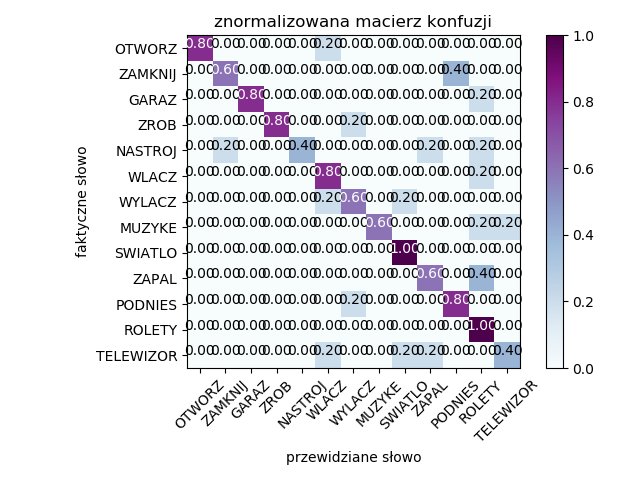

In [15]:
# tworzenie wykresu
mat = confusion_matrix(y_test, y_pred)
class_names = ['OTWORZ', 'ZAMKNIJ', 'GARAZ', 'ZROB', 'NASTROJ', 'WLACZ', 'WYLACZ', 'MUZYKE', 'SWIATLO', 'ZAPAL', 'PODNIES',
              'ROLETY', 'TELEWIZOR']


mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
plt.figure()
plt.imshow(mat, interpolation='nearest', cmap='BuPu')
plt.title('znormalizowana macierz konfuzji')
plt.colorbar()
plt.ylabel('faktyczne słowo')
plt.xlabel('przewidziane słowo')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
fmt = '.2f'
thresh = mat.max() / 2.
for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    plt.text(j, i, format(mat[i, j], fmt),
             horizontalalignment="center",
             color="white" if mat[i, j] > thresh else "black")


plt.show()